In [1]:
# I have to downgrade the version of scikit-learn because it's causing AttributeError: 'super' object has no attribute '__sklearn_tags__'
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.3.2

Found existing installation: scikit-learn 1.3.2
Uninstalling scikit-learn-1.3.2:
  Successfully uninstalled scikit-learn-1.3.2
  Using cached scikit_learn-1.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.9 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikeras 0.13.0 requires scikit-learn>=1.4.2, but you have scikit-learn 1.3.2 which is incompatible.


In [2]:
# Importing all the libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from pyswarms.single.global_best import GlobalBestPSO
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



In [3]:
# Loading theh dataset and seperate dataset into X and y.
df = load_iris()
X = df.data
y = df.target

In [4]:
# Performing one-hot encoding on the target variable y using the LabelBinarizer class from scikit-learn.
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [5]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
# Splitting the dataset into training and test set.
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=47)

In [28]:
# This function utilizies the sequential model from tensorflow to build the base model and compile it with adam optimizer.
def fun_model(learning_rate=0.01):
    model = Sequential([
        Dense(25, activation='relu', input_shape=(X.shape[1],)),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [29]:
# With the help of kerasClassifier, this block is doing the GridSearch.
model_grid = KerasClassifier(model=fun_model, optimizer__learning_rate=0.01, epochs=10, batch_size=16, verbose=0)
param_grid = {'optimizer__learning_rate': [0.001, 0.01, 0.1]}
grid = GridSearchCV(estimator=model_grid, param_grid=param_grid, cv=3)
grid_result = grid.fit(x_train, y_train)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

In [30]:
best_model_grid = fun_model(grid_result.best_params_['optimizer__learning_rate'])
best_model_grid.fit(x_train, y_train, epochs=30, batch_size=16, verbose=0)

In [31]:
y_pred_grid = best_model_grid.predict(x_test)
y_pred_grid = tf.argmax(y_pred_grid, axis=1)
y_test_labels = tf.argmax(y_test, axis=1)
acc_grid = accuracy_score(y_test_labels, y_pred_grid)
print(f"Baseline Accuracy (Grid Search): {acc_grid * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Baseline Accuracy (Grid Search): 93.33%


In [32]:
# PSO-Optimized Neural Network
def build_model_pso(learning_rate, neurons):
    model = Sequential([
        Dense(int(neurons), activation='relu', input_shape=(X.shape[1],)),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [33]:
# PSO fitness function  acts as an objective function that PSO uses to guide its search for the optimal hyperparameters.
def fitness_function(params):
    losses = []
    for lr, n in params:
        model = build_model_pso(lr, n)
        model.fit(x_train, y_train, epochs=20, batch_size=16, verbose=0)
        loss, acc = model.evaluate(x_test, y_test, verbose=0)
        losses.append(1 - acc)
    return np.array(losses)

In [34]:
# Updated PSO configuration
options = {'c1': 1.7, 'c2': 1.7, 'w': 0.5}
bounds = (np.array([0.0001, 4]), np.array([0.1, 128]))  # learning rate from 0.0001–0.1, neurons from 4–128
optimizer = GlobalBestPSO(n_particles=20, dimensions=2, options=options, bounds=bounds)

In [35]:
_, best_params = optimizer.optimize(fitness_function, iters=5)

2025-04-12 09:59:36,508 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 1.7, 'c2': 1.7, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
pyswarms.single.global_best: 100%|██████████|5/5, best_cost=0
2025-04-12 10:04:03,301 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [4.93814601e-02 1.15746892e+02]


In [36]:
# Final model with PSO parameters
best_lr, best_neurons = best_params
final_model = build_model_pso(best_lr, best_neurons)
final_model.fit(x_train, y_train, epochs=30, batch_size=16, verbose=1)

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5652 - loss: 0.6336  
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9326 - loss: 0.1779 
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9377 - loss: 0.1175 
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9306 - loss: 0.2043 
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9708 - loss: 0.1215 
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9616 - loss: 0.1287 
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9292 - loss: 0.1363 
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9665 - loss: 0.1087  
Epoch 9/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9683 - loss: 0.0796 
Epoch 10/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9918 - loss: 0.0374 
Epoch 11/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9802 - loss: 0.0424  
Epoch 12/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9632 - loss: 0.0650

In [37]:
# Evaluation
predictions = final_model.predict(x_test)
pred_labels = tf.argmax(predictions, axis=1)
y_test_labels = tf.argmax(y_test, axis=1)
acc_pso = accuracy_score(y_test_labels, pred_labels)
print(f"\n✅ Final Test Accuracy with PSO: {acc_pso * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step

✅ Final Test Accuracy with PSO: 96.67%


Precision (Grid Search): 0.93
Recall (Grid Search): 0.94
F1-Score (Grid Search): 0.93


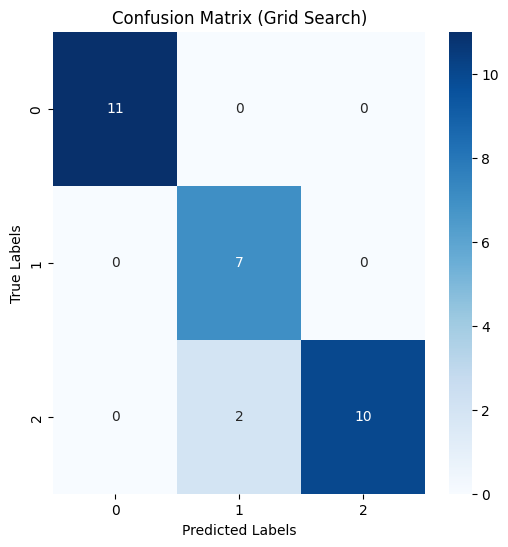


Precision (PSO): 0.96
Recall (PSO): 0.97
F1-Score (PSO): 0.96


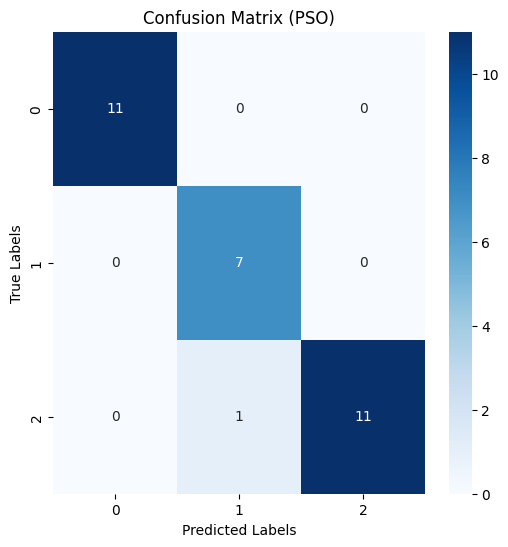

In [38]:
# Calculate additional metrics for Grid Search
precision_grid = precision_score(y_test_labels, y_pred_grid, average='macro')
recall_grid = recall_score(y_test_labels, y_pred_grid, average='macro')
f1_grid = f1_score(y_test_labels, y_pred_grid, average='macro')
conf_matrix_grid = confusion_matrix(y_test_labels, y_pred_grid)

print(f"Precision (Grid Search): {precision_grid:.2f}")
print(f"Recall (Grid Search): {recall_grid:.2f}")
print(f"F1-Score (Grid Search): {f1_grid:.2f}")

# Plot confusion matrix for Grid Search
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_grid, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_bin.classes_, yticklabels=label_bin.classes_)
plt.title('Confusion Matrix (Grid Search)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# Calculate additional metrics for PSO
precision_pso = precision_score(y_test_labels, pred_labels, average='macro')
recall_pso = recall_score(y_test_labels, pred_labels, average='macro')
f1_pso = f1_score(y_test_labels, pred_labels, average='macro')
conf_matrix_pso = confusion_matrix(y_test_labels, pred_labels)

print(f"\nPrecision (PSO): {precision_pso:.2f}")
print(f"Recall (PSO): {recall_pso:.2f}")
print(f"F1-Score (PSO): {f1_pso:.2f}")

# Plot confusion matrix for PSO
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_pso, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_bin.classes_, yticklabels=label_bin.classes_)
plt.title('Confusion Matrix (PSO)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [39]:
# prompt: print which learning rate used in baseline mode and learning rate and number of neuron from pso

print(f"Baseline learning rate: {grid_result.best_params_['optimizer__learning_rate']}")
print(f"PSO learning rate: {best_lr}")
print(f"PSO number of neurons: {best_neurons}")


Baseline learning rate: 0.1
PSO learning rate: 0.04938146007904784
PSO number of neurons: 115.74689210612179
